# The GGML method

In [1]:
import ggml_ot

This tutorial introduces and formalizes the *G*lobal *G*round *M*etric *L*earning (*GGML*) method with a small motivating example. We also give intuition on how the different concepts relate to patient-level single-cell data.

If you want to use the method on your data, have a look at [the tutorial on AnnData](../tutorials/ggml_anndata_tutorial.html).

## Motivating Example

Let's consider a small toy dataset containing three classes (colors) with 10 distributions each (symbols). 

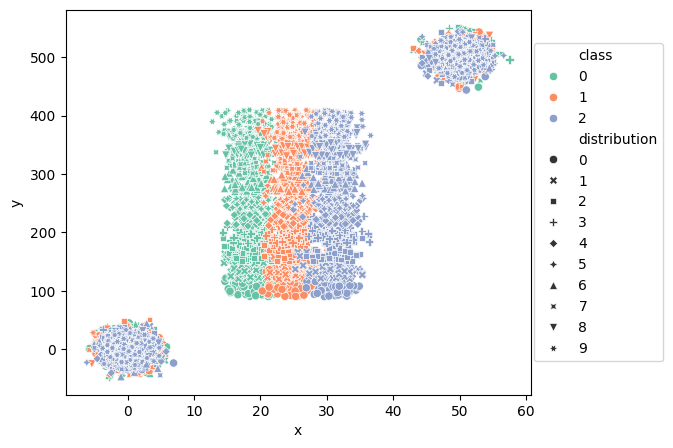

In [2]:
dataset = ggml_ot.data.from_synth()

Intuitively, you can think of the classes as disease states (e.g. <font color='#66c2a5'>control</font>, <font color='#fc8d62'>acute</font>, <font color='#8da0cb'>chronic</font>) and distributions as the cells measured from different patients (•,⨯,▪ ...) with the corresponding disease state. The x- and y-axis correspond to genes or gene loadings. The modes (or "cluster") of the distributions correspond to different cell-types. 

In this example, the only difference between disease states can be identified for the cell-type in the center along the x-axis. 

## Optimal Transport

The Optimal Transport distance between two empirical distributions $\mathcal{X}$ and $\mathcal{Y}$ is defined as:
$$
\quad OT(\mathcal{X},\mathcal{Y}) = \min_{\pi}\sum_{x,y} d(x,y) \pi_{x,y}
$$

where $d(x,y)$ is the ground metric, a function that determines the cost of moving mass between $x \sim \mathcal{X}$ and $y \sim \mathcal{Y}$. The transport plan $\pi$ is a mapping between the marginals of $\mathcal{X}$ and $\mathcal{Y}$. The OT distance is then the minimal cost of the optimal transport plan, a measure of similarity between the distributions $\mathcal{X}$ and $\mathcal{Y}$.

### Euclidean Ground Metric

A commonly used ground metric is the euclidean distance $d(x,y) = ||x-y||_2$, where the OT distance corresponds to the popular (squared) Wasserstein-2 distance. 
$$
\quad W_2(\mathcal{X},\mathcal{Y})^2 = \min_{\pi}\sum_{x,y} ||x-y||_2 \pi_{x,y}
$$

Let's compute the Optimal Transport distance on the example dataset using the Euclidean distance as a ground metric.

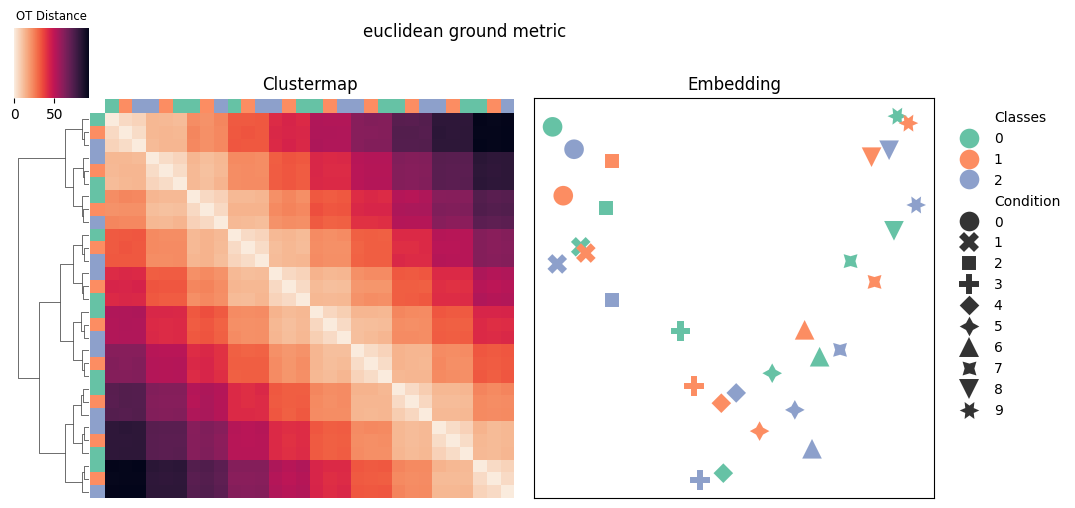

In [3]:
D_euclidean = dataset.compute_OT(ground_metric="euclidean", plot=True)

As you can see, the class differences along the x-axis are not captured as the euclidean metric can not differentiate between class-related differences on the x-axis and unrelated differences on the y-axis.

## Learn Ground Metric

Now, we perform Supervised Optimal Transport with GGML. It trains a Ground Metric such that the Optimal Transport distance between distributions captures their known class relationships. We plot the learned metric after each epoch.

### Ground Metric:
$$
\quad W_2(\mathcal{X},\mathcal{Y};\Theta)^2 = 
\inf_{\pi}\int_{\mathcal{X} \times \mathcal{Y}} d(x,y;\Theta)^2 d\pi(x,y)
$$
Here, we introduced the notation of some parameters $\Theta$ to indicate that $d$ is a parameterized metric.

---
### Triplet Learning:

$$
\mathcal{L}_\alpha(X,\mathcal{T};\Theta) =  \sum\limits_{t\in\mathcal{T} } \mathcal{L}_\alpha(X,t;\Theta)
$$

$$
\text{where} \: \mathcal{L}_\alpha(X,(i,j,k);\Theta) = \\
\max \left( W(X_i,X_j;\Theta) - W(X_j,X_k;\Theta) + \alpha, 0 \right) 
$$

---
### Generalized Mahalanobis Distance:
$$
\begin{align}
d(\mathbf{x}_i,\mathbf{x}_j;\mathbf{M} ) &= \sqrt{(\mathbf{x}_i-\mathbf{x}_j)^T \mathbf{M} (\mathbf{x}_i - \mathbf{x}_j)}  \nonumber \\
&= \lVert \mathbf{A}\mathbf{x}_i-\mathbf{A}\mathbf{x}_j \rVert =: d(\mathbf{x}_i,\mathbf{x}_j;\mathbf{A}) \nonumber \\
s.t. \;\mathbf{A}^T\mathbf{A} &= (\mathbf{Q} \Lambda^{\frac{1}{2}}) (\mathbf{Q} \Lambda^{\frac{1}{2}})^T =  \mathbf{Q} \Lambda \mathbf{Q}^T = \mathbf{M}  \nonumber
\end{align}
$$

Compute all OT distances after 1 iterations


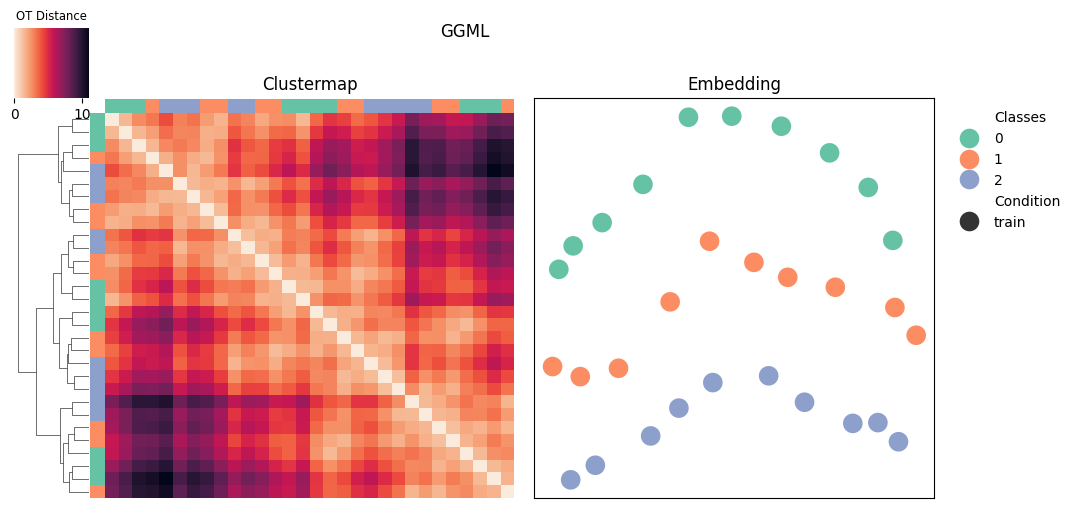

Compute all OT distances after 2 iterations


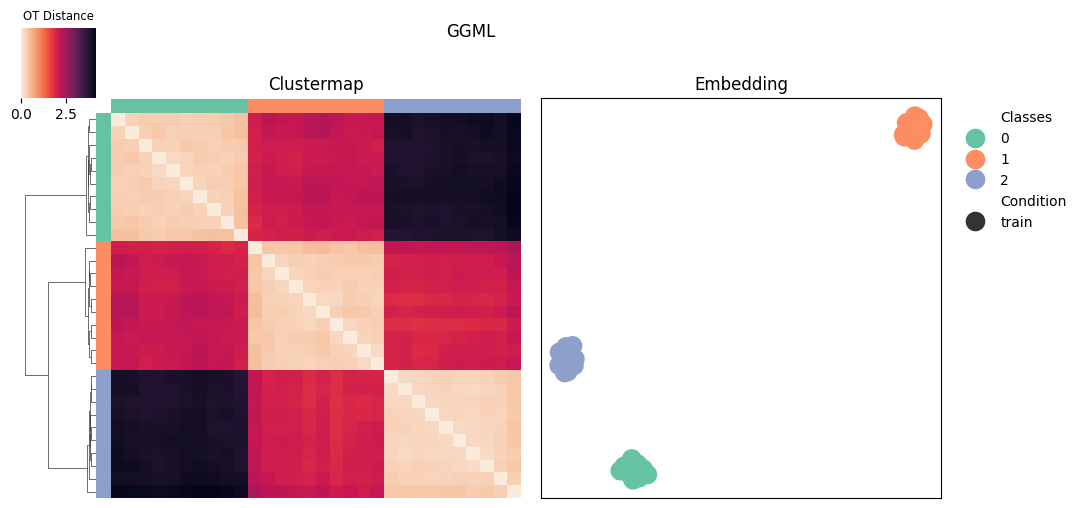

Compute all OT distances after 3 iterations


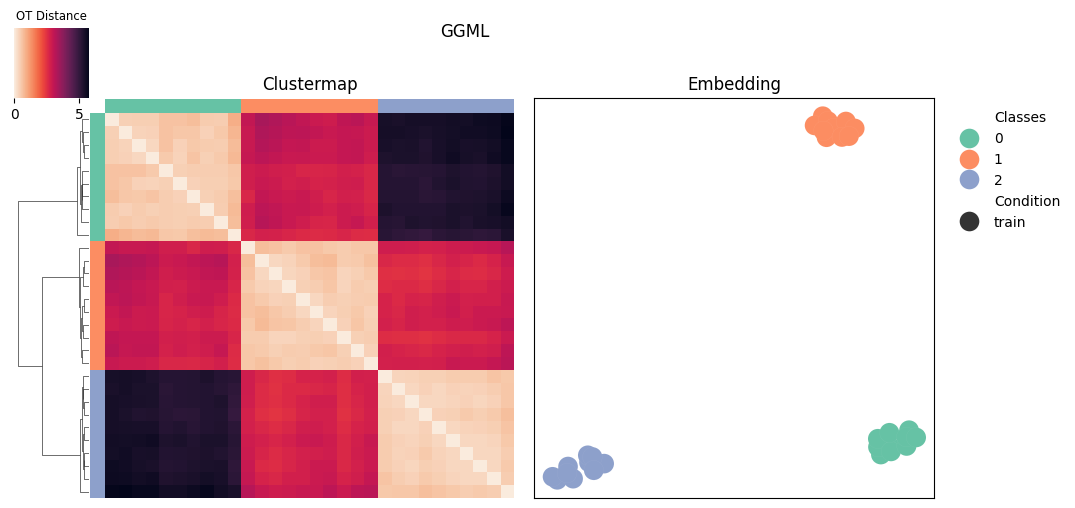

Compute all OT distances after 4 iterations


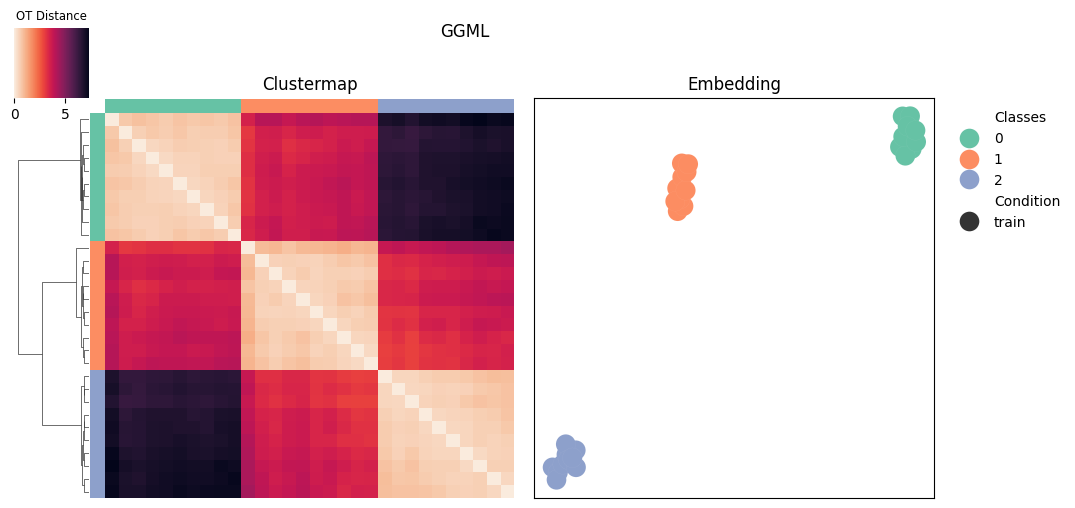

In [4]:
w_theta = dataset.train(reg_type=1, n_comps=2, max_iter=4, plot_iter=1)